# Scientific Computing + Machine Learning = Scientific Machine Learning

John Waczak  
Jun 18 2021  
Lary Research Group  

# Overview
1. **Scientific Computing In Julia**
    - Differential Equations
    - Matrix Computing 
    - Unitful.jl + Measurements.jl
3. **Automatic Differentiation**
    - Forward Mode
    - Reverse Mode 
    - Which to Use
4. **Differentiable Programming: Language wide AD**
5. **Scientific Machine Learning**
    - What is a Neural Network, Really? 
    - Fitting DiffEqs with Neural Networks
    - Physics-Informing our Neural Networks via Intelligent Regularization
    - Universal Differential Equations
    - Sparse Regression and Physics Identification

# 1. Scientific Computing in Julia 
## aka the Julia Sales Pitch 
- Dynamically Typed (ease of use)
- Just-in-time compiled (speed) 
- Multiple Dispatch Paradigm (scientifically minded, not GUI minded)
    - Abstract Typing System 
    - Focus on writing generic algorithms that are type agnostic
    - An Image is just an interpretation of an Abstract Array $\to$ most image processing codes work regardless of array type
- (best reason) you can use any unicode character for variables... **no more typing out theta, delta, gamma, etc...**
    - also, docstrings are interpreted as markdown which makes it super easy to make rich documentation

In [124]:
Γ = 12

12

# 1.1 Differential Equations
- Accomplished via `DifferentialEquations.jl`. See [here](https://diffeq.sciml.ai/stable/)
- Example: Lorenz Equations 
\begin{align}
    \dot{x} &= \sigma(y-x) \\ 
    \dot{y} &= x(\rho-z)-y \\
    \dot{z} &= xy - \beta z 
\end{align}
- Can use in-place form (faster) $f(du, u, p, t)$, or out-of-place $f(u, p, t)$. 

In [1]:
using DifferentialEquations
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [2]:
# 1. define ODE system
function lorenz(du, u, p, t)
    du[1] = p[1]*(u[2]-u[1])
    du[2] = u[1]*(p[2]-u[3]) - u[2]
    du[3] = u[1]*u[2] - p[3]*u[3]
end

lorenz (generic function with 1 method)

In [3]:
# 2. Define IC/BC, time values, and parameters
u₀ = [1.0, 0.0, 0.0]  # initial condition
tspan = (0.0, 100.0)
p = (10.0, 28.0, 8/3) # parameter values

(10.0, 28.0, 2.6666666666666665)

In [4]:
# define the problem and solve the problem
prob = ODEProblem(lorenz, u₀, tspan, p)
sol = solve(prob)

retcode: Success
Interpolation: automatic order switching interpolation
t: 1300-element Vector{Float64}:
   0.0
   3.5678604836301404e-5
   0.0003924646531993154
   0.003262408518896374
   0.009058077168386882
   0.01695647153663815
   0.027689960628879868
   0.041856351821061455
   0.06024041060823337
   0.08368540639551347
   0.11336498387118026
   0.14862180073662978
   0.18703976749175058
   ⋮
  98.96497153541497
  99.06972158785038
  99.15733553336672
  99.25227436435598
  99.34990050231407
  99.47329750836677
  99.56888278883171
  99.68067056500875
  99.7698930548574
  99.86396908592394
  99.9520070464327
 100.0
u: 1300-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.9996434557625105, 0.0009988049817849058, 1.781434788799189e-8]
 [0.9961045497425811, 0.010965399721242457, 2.1469553658389193e-6]
 [0.9693591566959717, 0.089770627357676, 0.0001438019004555601]
 [0.9242043510496474, 0.24228916412927515, 0.0010461626692665619]
 [0.8800455755115648, 0.43873651254178225, 0.0034242

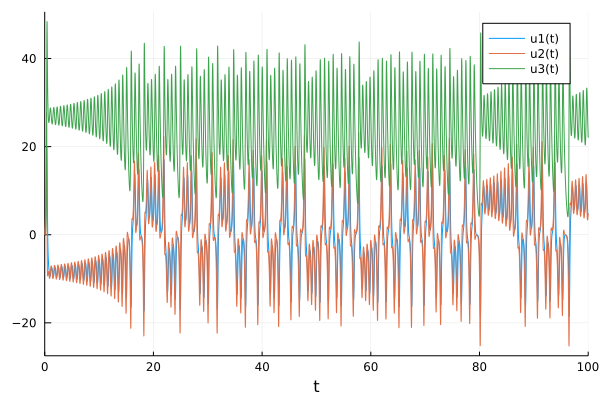

In [5]:
# plot the solution with simple 
# plotting recipes
plot(sol)

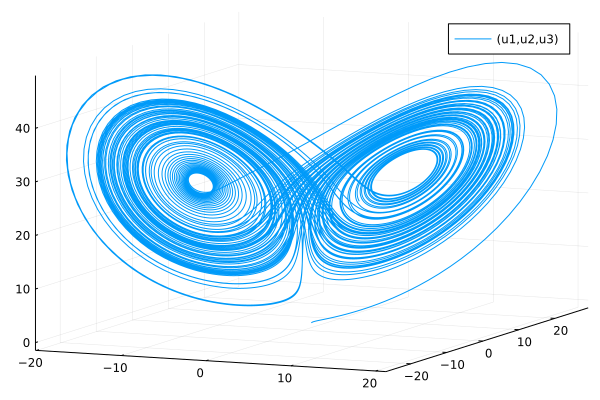

In [6]:
plot(sol, vars=(1, 2, 3)) # 3d plot

- This is a simple system, how does `DifferentialEquations` do for more complex problems? 
- Julia has **the most advanced DiffEq suite out there***TM*
- You can pick which method to use, but `DifferentialEquations` has out-of-the-box heuristics for stiffness detection (later) and can automatically switch between methods on the fly

![](./diffeq_comparison.png)

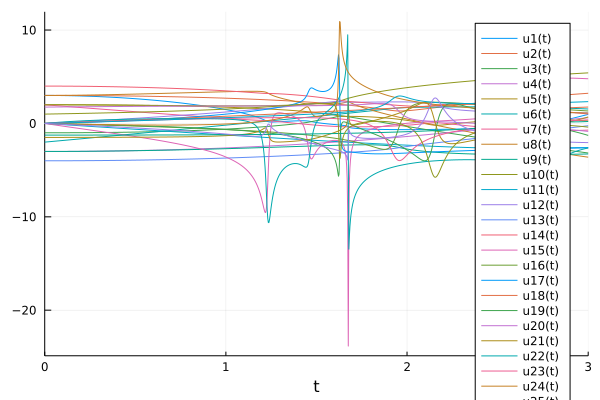

In [7]:
# Ex: Astrophysics
# Pleiades problem for orbits of 7 stars
function pleiades(du,u,p,t)
    @inbounds begin
        x = view(u,1:7)   # x
        y = view(u,8:14)  # y
        v = view(u,15:21) # x′
        w = view(u,22:28) # y′
        du[1:7] .= v
        du[8:14].= w
        for i in 15:28
            du[i] = zero(u[1])
        end
        for i=1:7,j=1:7
            if i != j
                r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
                du[14+i] += j*(x[j] - x[i])/r
                du[21+i] += j*(y[j] - y[i])/r
            end
        end
    end
end

tspan = (0.0,3.0)
prob = ODEProblem(pleiades,[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,3.0,-3.0,2.0,0,0,-4.0,4.0,0,0,0,0,0,1.75,-1.5,0,0,0,-1.25,1,0,0],tspan)
sol = solve(prob)
plot(sol)

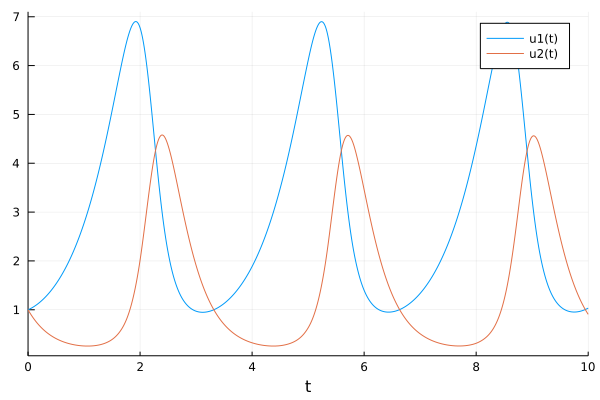

In [8]:
# Ex: Population Dynamics
function lotka(du, u, p, t)
    du[1] = p[1]*u[1] - p[2]*u[1]*u[2]
    du[2] = -p[3]*u[2] + p[4]*u[1]*u[2]
end

p = [1.5, 1.0, 3.0, 1.0]
prob = ODEProblem(lotka, [1.0, 1.0], (0.0, 10.0), p)
sol = solve(prob)
plot(sol)

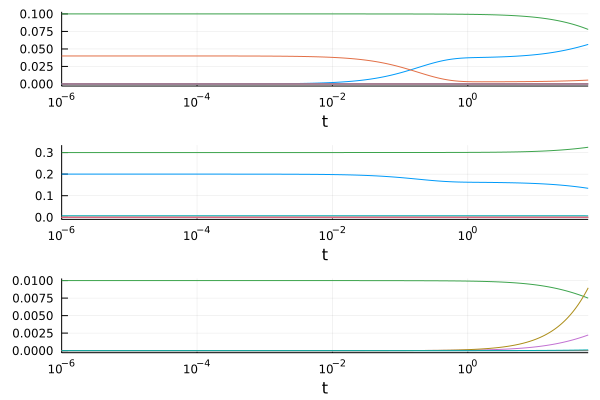

In [10]:
# Exmaple Stiff Chemical Reaction Model

k1=.35e0
k2=.266e2
k3=.123e5
k4=.86e-3
k5=.82e-3
k6=.15e5
k7=.13e-3
k8=.24e5
k9=.165e5
k10=.9e4
k11=.22e-1
k12=.12e5
k13=.188e1
k14=.163e5
k15=.48e7
k16=.35e-3
k17=.175e-1
k18=.1e9
k19=.444e12
k20=.124e4
k21=.21e1
k22=.578e1
k23=.474e-1
k24=.178e4
k25=.312e1
p = (k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,k21,k22,k23,k24,k25)
function f(dy,y,p,t)
    k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,k21,k22,k23,k24,k25 = p
    r1  = k1 *y[1]
    r2  = k2 *y[2]*y[4]
    r3  = k3 *y[5]*y[2]
    r4  = k4 *y[7]
    r5  = k5 *y[7]
    r6  = k6 *y[7]*y[6]
    r7  = k7 *y[9]
    r8  = k8 *y[9]*y[6]
    r9  = k9 *y[11]*y[2]
    r10 = k10*y[11]*y[1]
    r11 = k11*y[13]
    r12 = k12*y[10]*y[2]
    r13 = k13*y[14]
    r14 = k14*y[1]*y[6]
    r15 = k15*y[3]
    r16 = k16*y[4]
    r17 = k17*y[4]
    r18 = k18*y[16]
    r19 = k19*y[16]
    r20 = k20*y[17]*y[6]
    r21 = k21*y[19]
    r22 = k22*y[19]
    r23 = k23*y[1]*y[4]
    r24 = k24*y[19]*y[1]
    r25 = k25*y[20]

    dy[1]  = -r1-r10-r14-r23-r24+
            r2+r3+r9+r11+r12+r22+r25
    dy[2]  = -r2-r3-r9-r12+r1+r21
    dy[3]  = -r15+r1+r17+r19+r22
    dy[4]  = -r2-r16-r17-r23+r15
    dy[5]  = -r3+r4+r4+r6+r7+r13+r20
    dy[6]  = -r6-r8-r14-r20+r3+r18+r18
    dy[7]  = -r4-r5-r6+r13
    dy[8]  = r4+r5+r6+r7
    dy[9]  = -r7-r8
    dy[10] = -r12+r7+r9
    dy[11] = -r9-r10+r8+r11
    dy[12] = r9
    dy[13] = -r11+r10
    dy[14] = -r13+r12
    dy[15] = r14
    dy[16] = -r18-r19+r16
    dy[17] = -r20
    dy[18] = r20
    dy[19] = -r21-r22-r24+r23+r25
    dy[20] = -r25+r24
end

u0 = zeros(20)
u0[2]  = 0.2
u0[4]  = 0.04
u0[7]  = 0.1
u0[8]  = 0.3
u0[9]  = 0.01
u0[17] = 0.007
prob = ODEProblem(f,u0,(0.0,60.0),p)
sol = solve(prob)

plot(sol)
plot(sol, xscale=:log10, tspan=(1e-6, 60), layout=(3,1), legend=false)

# 1.2 Matrix Computing
- This is just like Matlab, Numpy etc
- convenient "." syntax for broadcasting

In [12]:
A = [1 2 3; 4 1 6; 7 8 1]

3×3 Matrix{Int64}:
 1  2  3
 4  1  6
 7  8  1

In [14]:
using LinearAlgebra

In [15]:
tr(A)

3

In [16]:
det(A)

104.0

In [17]:
inv(A)

3×3 Matrix{Float64}:
 -0.451923   0.211538    0.0865385
  0.365385  -0.192308    0.0576923
  0.240385   0.0576923  -0.0673077

In [20]:
b = [1; 1; 5]

# solve Ax = b 
A\b  # <-- this defaults to least squares for overdetermined systems

3-element Vector{Float64}:
  0.19230769230769232
  0.4615384615384615
 -0.03846153846153844

In [21]:
eigvals(A)

3-element Vector{Float64}:
 -6.214612641961068
 -1.5540265964847833
 10.768639238445843

In [22]:
eigvecs(A)

3×3 Matrix{Float64}:
 -0.175709  -0.766257  -0.344989
 -0.570057   0.587185  -0.589753
  0.802596   0.26089   -0.730188

In [23]:
factorize(A) # simple LU factorization

LU{Float64, Matrix{Float64}}
L factor:
3×3 Matrix{Float64}:
 1.0        0.0   0.0
 0.571429   1.0   0.0
 0.142857  -0.24  1.0
U factor:
3×3 Matrix{Float64}:
 7.0   8.0      1.0
 0.0  -3.57143  5.42857
 0.0   0.0      4.16

# 1.3 Unitful.jl and Measurements.jl 
- `Unitful.jl` enables the JIT to track physical units of your data
- `Measurments.jl` enables adding uncertaintites to numeric types
    - computations on measurements propagate the uncertainties correctly

In [26]:
using Unitful
using Measurements

In [29]:
m = 10u"kg"
L = (10*π)u"m" 
T = 4.123u"s"

4.123 s

In [30]:
m*L*T

1295.2786510750718 kg m s

In [32]:
m*L/T^2

18.48090366035691 kg m s^-2

In [33]:
m+T # catch the dimension missmatch

LoadError: DimensionError: 10 kg and 4.123 s are not dimensionally compatible.

In [40]:
u"μm"(L) # unit conversion

3.1415926535897933e7 μm

In [125]:
x = 1:0.01:10
y = [(x[i] ± 0.5*x[i]/i) for i ∈ 1:length(x)]
a = 10 ± 3

10.0 ± 3.0

In [44]:
y[1] + y[2]

2.01 ± 0.56

In [45]:
y[2]*y[2]

1.02 ± 0.51

In [46]:
sin.(y) # correctly use calculus to progpagate uncertainties

901-element Vector{Measurement{Float64}}:
    0.84 ± 0.27
    0.85 ± 0.13
   0.852 ± 0.089
   0.857 ± 0.066
   0.862 ± 0.053
   0.867 ± 0.044
   0.872 ± 0.037
   0.877 ± 0.032
   0.882 ± 0.028
   0.887 ± 0.025
   0.891 ± 0.023
   0.896 ± 0.021
     0.9 ± 0.019
         ⋮
 -0.4486 ± 0.005
 -0.4575 ± 0.0049
 -0.4664 ± 0.0049
 -0.4752 ± 0.0049
  -0.484 ± 0.0049
 -0.4927 ± 0.0048
 -0.5014 ± 0.0048
   -0.51 ± 0.0048
 -0.5186 ± 0.0047
 -0.5271 ± 0.0047
 -0.5356 ± 0.0047
  -0.544 ± 0.0047

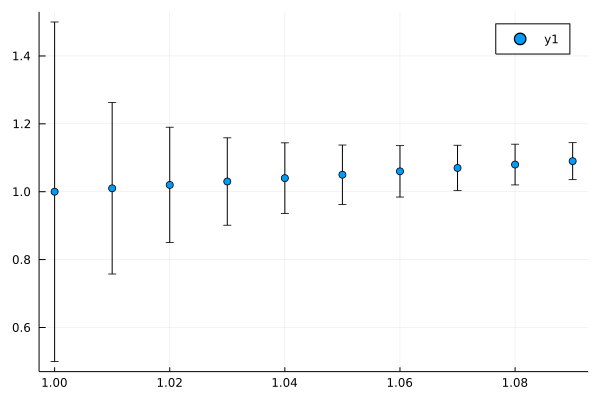

In [49]:
# plotting recipes means plots knows automatically how to deal
# with measurments by adding error bars
plot(x[1:10], y[1:10], seriestype=:scatter)

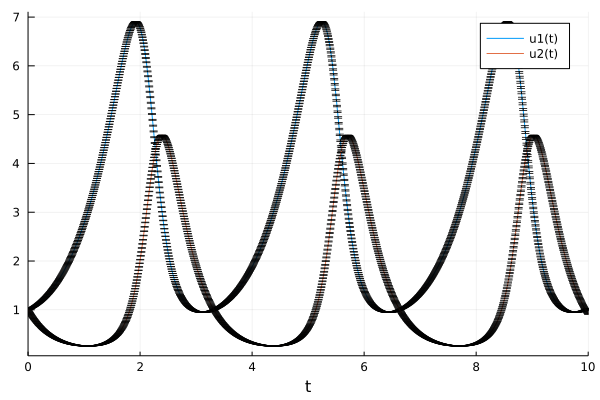

In [126]:
p = [1.5, 1.0, 3.0, 1.0]
prob = ODEProblem(lotka, [1.0±0.001, 1.0±0.001], (0.0, 10.0), p)
sol = solve(prob)
plot(sol)

# Thoughts
- Abstract types lead to cross-package compatability for little effort
- We should try using `Unitful` and `Measurements` in 
    - small neural networks in `Flux` 
    - other ML models from `MLJ` 

# 2. The Backbone of ML: Automatic Differentiation

# 2.1 Forward-Mode AD via Dual Numbers
- Differentiating functions analytically is hard and doesn't work for *most* functions 
- Numerical differentiation via finite differences is easy, but has issues with accuracy, machine error, etc... 
\begin{equation}
    f'(x) \approx \frac{f(x+\Delta x)-f(x)}{\Delta x}
\end{equation}
- Can we do better? 
- **Idea:** Separate the $\Delta x$ from the $x$ in the computation!

# Finite Differencing with Complex Numbers
- Taylor expand $f$ a distance $h$ way from the real line
\begin{align}
    f(x+ih) &= f(x) + f'(x)(ih) + \mathcal{O}(h^2) \\ 
    if'(x) &= \frac{f(x+ih)-f(x)}{h} + \mathcal{O}(h) \\ 
    \Rightarrow f'(x) &= \frac{\text{Im}(f(x+ih))}{h} + \mathcal{O}(h)
\end{align}
where we have used that $f(x)$ is real
- Upshot: $h$ never directly interacts with $x$! 
  - No numerical cancellation by using a small value of $h$, we can use machine $\epsilon$ worth of precision! 

# Dual Numbers
- extend complex differentiation to functions that aren't necessarily analytic
- envision a new number type called a *dual number*
- propagate the derivative along the *dual part*
- For this to work, we need to derive the *Algebra of dual numbers*
- Consider Taylor series to first order
\begin{equation}
    f(a+\epsilon) = f(a) + \epsilon f'(a)
\end{equation}
- ignore higher order terms because we only care about propagating the first derivative
  - formally, set $\epsilon^2 = 0$ (like $i^2=-1$)
given 
\begin{align}
    f(x) &\rightsquigarrow f(x) + \epsilon f'(x) \\ 
    g(x) &\rightsquigarrow g(x) + \epsilon g'(x)
\end{align}
where $\rightsquigarrow$ denotes extension to a *dual number representation*
- then sum and product rules become:  
\begin{align}
    f + g & \rightsquigarrow \left[ f + g \right] + \epsilon \left[f' + g' \right] \\ 
    f \cdot g &\rightsquigarrow \left[ f\cdot g \right] + \epsilon \left[ f\cdot g' + g\cdot f' \right]
\end{align}
- thus we can *infer* the derivative by taking the *dual part* of the result

In [50]:
# in Julia
struct Dual{T}
    val::T # value
    der::T # derivative
end

# define algebra of dual numbers by extending Julia Base
#  sum rules
Base.:+(f::Dual, g::Dual) = Dual(f.val + g.val, f.der + g.der)
Base.:+(f::Dual, α::Number) = Dual(f.val + α, f.der)
Base.:+(α::Number, g::Dual) = g + α
Base.:-(f::Dual, g::Dual) = Dual(f.val - g.val, f.der - g.der)

#  product rules
Base.:*(f::Dual, g::Dual) = Dual(f.val*g.val, f.der*g.val + f.val*g.der)
Base.:*(f::Dual, α::Number) = Dual(f.val*α, f.der*α)
Base.:*(α::Number, g::Dual) = g*α

#  quotient rules
Base.:/(f::Dual, g::Dual) = Dual(f.val/g.val, (f.der*g.val - f.val*g.der)/(g.val)^2)
Base.:/(f::Dual, α::Number) = f * inv(α)
Base.:/(α::Number, g::Dual) = Dual(α/g.val, -α*f.der/f.val^2)

#  power rule
Base.:^(f::Dual, n::Integer) = Base.power_by_squaring(f, n) # just square f n times

In [51]:
# test it out:
F = Dual(3, 4)
G = Dual(5, 6)

Dual{Int64}(5, 6)

In [52]:
F+G

Dual{Int64}(8, 10)

In [53]:
F * (G + G)

Dual{Int64}(30, 76)

In [54]:
# make life easier by defining primitives
# defining higher order primitives
Base.exp(f::Dual) = Dual(exp(f.val), exp(f.val)*f.der) # i.e. [e^(f(x))]' = e^(f(x))f'(x)
exp(F)

Dual{Float64}(20.085536923187668, 80.34214769275067)

In [127]:
# differentiating arbitrary function
h(x) = x^2 + 2  # typical function
xx = Dual(3, 1) # define a dual number
h(xx) # change the algebra! h'(x) = 2x

Dual{Int64}(11, 6)

# application: Newton's method in N-dimensions

In [56]:
using ForwardDiff

In [57]:
function newtons_method_step(f, x0)
    J = ForwardDiff.jacobian(f, x0)
    δ = J \ f(x0)  # x_k = x_{k-1}-J^{-1}f(x_{k-1})
    return x0-δ # next position
end


function newtons_method(f, x0, N=10)
    x = x0
    for i in 1:N
        x = newtons_method_step(f, x)
        @show x
    end

    return x
end

newtons_method (generic function with 2 methods)

In [58]:
# find the zero of the following vector field
ff(x) = [ x[1]^2, x[2]^2]  # the zero is at (0, 0)
newtons_method(ff, [10.0, 10.0], 20)

x = [5.0, 5.0]
x = [2.5, 2.5]
x = [1.25, 1.25]
x = [0.625, 0.625]
x = [0.3125, 0.3125]
x = [0.15625, 0.15625]
x = [0.078125, 0.078125]
x = [0.0390625, 0.0390625]
x = [0.01953125, 0.01953125]
x = [0.009765625, 0.009765625]
x = [0.0048828125, 0.0048828125]
x = [0.00244140625, 0.00244140625]
x = [0.001220703125, 0.001220703125]
x = [0.0006103515625, 0.0006103515625]
x = [0.00030517578125, 0.00030517578125]
x = [0.000152587890625, 0.000152587890625]
x = [7.62939453125e-5, 7.62939453125e-5]
x = [3.814697265625e-5, 3.814697265625e-5]
x = [1.9073486328125e-5, 1.9073486328125e-5]
x = [9.5367431640625e-6, 9.5367431640625e-6]


2-element Vector{Float64}:
 9.5367431640625e-6
 9.5367431640625e-6

# Forward Mode AD in More Dimensions
- Consider functions $f:\mathbb{R}^n\to\mathbb{R}$
- $\epsilon \rightarrow \epsilon_i$ where $\epsilon_i\epsilon_j = \epsilon_i^2 = 0$.
- $\vec{\epsilon}$ is the vector of perturbations
\begin{equation}
    f(\vec{x} + \vec{\epsilon}) = f(\vec{x}) + \nabla f(\vec{x}) \cdot \vec{\epsilon} + \mathcal{O}(\epsilon^2)
\end{equation}
- $\nabla f(\vec{x})$ is the gradient of $f$ at $\vec{x}$
- $\nabla f(\vec{x})\cdot\vec{\epsilon}$ is the **Directional Derivative** of $f$ in direction $\vec{\epsilon}$ at $\vec{x}$

-similarly, we can define the algebra for **vector-valued dual numbers**
\begin{align}
    (f+g)(\vec{a}+\vec{\epsilon}) &= \left[ f(\vec{a}) + g(\vec{a})\right] + \left[ \nabla f (\vec{a}) + \nabla g(\vec{a}) \right]\cdot \vec{\epsilon} \\ 
    (f*g)(\vec{a}+\vec{\epsilon}) &= \left[ f(\vec{a}) + \nabla f(\vec{a})\cdot \vec{\epsilon} \right] \left[ g(\vec{a}) + \nabla g(\vec{a})\cdot \vec{\epsilon} \right] \\ 
    &= f(\vec{a})g(\vec{a}) + \left[ f(\vec{a})\nabla g(\vec{a}) + g(\vec{a})\nabla f(\vec{a}) \right]\cdot \vec{\epsilon}
\end{align}

From this we can clearly see that the directional derivative in some arbitrary direction can be easily calculated via 
\begin{equation}
    \text{Dual}\big[ f(\vec{x} + \epsilon\vec{v}) \big] = \text{Dual}\big[ f(\vec{x})+\epsilon\nabla f(\vec{x})\cdot \vec{v} \big] = \nabla f(\vec{x})\cdot\vec{v}
\end{equation}
or in julia, `f(Dual(x_vec, v_vec)).der`



# Conclusion: Forward-Mode AD is JVP
- for general functions $f:\mathbb{R}^n\to\mathbb{R}^m$, we can equivalently think of component functions
- $f_i:\mathbb{R}^n\to\mathbb{R}$, $i=1...m$.
\begin{align}
    f(\vec{x}+\epsilon\vec{v}) &= \sum_i f_i(\vec{x}+\epsilon\vec{v})\vec{e}_i \\ 
    &= \sum_i f_i(\vec{x})\vec{e}_i + \sum_j\epsilon\left[\nabla f_j(\vec{x})\cdot\vec{v}\right]\vec{e}_j \\ 
    &= f(\vec{x}) + \epsilon\sum_j\Big[\sum_i \frac{df_j}{dx_i}v_i\Big]\vec{\epsilon}_j \\ 
    &= f(\vec{x}) + \Big[ f'(\vec{x})\cdot \vec{v}\Big]\epsilon
\end{align}
where $f'(\vec{x}) = J = \Big[ \dfrac{\partial f_i}{\partial x_j}\Big]$ is the Jacobian
- Thus forward-mode AD reduces to the Jacobian-vector-product (jvp)




# 2.2 Reverse-Mode AD: Backpropagation
- many names for this technique: 
  - the adjoint technique 
  - backpropogation 
  - reverse-mode automatic differentiation
- recall multivariate chain rule for $f\Big(x(t), y(t)\Big)$
\begin{equation}
    f\Big(x(t), y(t)\Big) = \frac{df}{dx}\frac{dx}{dt} + \frac{df}{dy}\frac{dy}{dy}
\end{equation}
- if we add another layer, i.e. $f\Big(x\big(v(t), w(t)\big), y\big(v(t), w(t)\big)\Big)$, the previous statement is correct, we now must update $dx/dt$ and $dy/dt$, i.e. 
\begin{equation}
    \frac{dx}{dt} = \frac{dx}{dv}\frac{dv}{dt} + \frac{dx}{dw}\frac{dw}{dt}
\end{equation}
- Upshot: use the chain rule to compute $\dfrac{df}{dt}$ by going backwards *up the computational graph*
  1. compute $\frac{df}{dx}$ and $\frac{df}{dy}$
  2. compute $\frac{dx}{dt}$ and $\frac{dy}{dt}$ 
  3. combine via chain rule to compute $\frac{df}{dt}$
- in other words, we **pull back** the derivatives through the layers
This is the concept of the **Backward Pass** for backpropogation of gradients. Once we send data though the network to calculate $f$, we can run the network in reverse to track the gradients and determine the Jacobian. *this saves us from having to track the gradients at every step of the network*

## Simple Example: Logistic Regression
Consider the following model that maps inputs $x$ to outputs $y$. 
\begin{align}
    z &:= wx + b \qquad \text{(linear fit)} \\
    y &:= \sigma(z) \qquad \text{(nonlinear activation)}\\
    \mathcal{L} &:= \frac{1}{2}(y-t)^2 \qquad \text{(loss)} \\ 
    \mathcal{R} &:= \frac{1}{2}w^2 \qquad \text{(regularizer)} \\ 
    \mathcal{L}_{reg} &:= \mathcal{L}+ \lambda\mathcal{R} \qquad \text{(composed loss)}
\end{align}
- Graph based formulations like this are called: 
  - Wengert lists 
  - tapes
  - graphs
- Calculate the derivatives in the reverse order 
  - Our cost function is $f(x)=\mathcal{L}_{reg}$ so $\dfrac{df}{d\mathcal{L}_{reg}} = 1$
    - define $\overline{\mathcal{L}_{reg}}:= \frac{df}{d\mathcal{L}_{reg}}=1$
  - Second to last layer:
    - $\overline{\mathcal{R}} = \frac{df}{d\mathcal{L}_{reg}}\frac{d\mathcal{L}_{reg}}{d\mathcal{R}} = \overline{\mathcal{L}}_{reg}\lambda$
    - $\overline{\mathcal{L}} = \frac{df}{\mathcal{L}_{reg}}\frac{d\mathcal{L}_{reg}}{d\mathcal{L}} = \overline{\mathcal{L}}_{reg}$
  - next layer: 
    - $\overline{y} = \overline{\mathcal{L}}\frac{d\mathcal{L}}{dy}=\overline{\mathcal{L}}(y-t)$
  - next layer: 
    - $\overline{z} = \overline{y}\frac{dy}{dz}= \overline{y}\sigma'(z)$
  - final layer: 
    - $\overline{w} = \overline{z}\frac{dz}{dw} + \overline{\mathcal{R}}\frac{d\mathcal{R}}{dw}= \overline{z}x + \overline{R}w$
    - $\overline{b} = \overline{z}\frac{dz}{db} = \overline{z}$
- We have now calculated all of the derivatives+



# Reverse-Mode AD is just a VJP
- A concise way to write this process is via the **pullback** function. 
- let $f$ be a function that maps $f:x\mapsto y$, then the pullback of $f$ at the point $x$ with respect to the scalar loss function $L(y)$ is 
\begin{align}
    \mathcal{B}_f^x(\overline{y}) &:= \overline{x} \\  
    &= \frac{dL}{dx_j} = \sum_i\frac{dL}{dy_i}\frac{dy_i}{dx_j} \\ 
    &= \sum_i \overline{y}_i \frac{dy_i}{dx_j} \\ 
    &= \overline{y}\cdot \left[ \frac{dy_i}{dx_j}\right]
\end{align}
where in the last line it becomes clear that we are left multiplying the Jacobian $dy_i/dx_j$ bv the *adjoint* of the vector $y$, called $\overline{y}$.
- If we don't have a primitive for how to compute $\overline{y}$, then we can continue employing pullbacks until we get to primitives we do know      

## Which mode is better? 
- Forward-Mode AD utilizes jvp i.e. computing with columns of the Jacobian
- Reverse-Mode AD utilizes vjp i.e. computing with rows of the Jacobian
- Therefore if your model can be represented by $f:\mathbb{R}^n\to\mathbb{R}^m$, then the Jacobian is of size $m\times n$. 
  - if $m << n$, i.e. you have a very deep network, then computing with rows of $J$ is faster $\rightarrow$ use Reverse-Mode AD 
    - special case: $m=1$ computing the gradient of a scalar $f:\mathbb{R}^n\to\mathbb{R}$
  - if $n << m$, i.e. you have a shallow model, then use Forward-Mode AD
    - Storing the computational graph (aka gradient tape) tends to have high overhead, so when $m\approx n$, you should use Forward-Mode
    - one can even take a *mixed-mode* approach
    
[usefull notes](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/**




# 3. $\partial$D: Language-Wide AD
- Reverse-mode is nice, but tracking a computational graph is difficult, expensive, and can easily become excessively complex for large models. 
- Goal: *Make differentiation a **language-wide** feature*, i.e. institute **Differentiable Programming**
- This necessitates
  - a way to implement Reverse-Mode AD on an *entire language*
  - a systematic way to derive *adjoints* (pullbacks)
  - a better way to fit parameters to data, rather than performing AD through entire programs

## Implementation of Reverse-Mode AD
Forward mode was implemented by overloading operators and defining `::Dual` number types. Reverse mode is trickier... how do we actually do it? 
### Static Graph AD
- define a static compute graph (you already wrote your code, right?)
- Tensorflow does this 
  - user defines variables, operations, and functions using an embedded graph language, i.e. `tf.tensor()` instead of `np.ndarray()`
  - execution on graph is then easy to differentiate (just follow the graph backwards)
- This is a large barrier to practical use because *all code already written must be refactored into the graph language* (you cant use `scipy` functions inside of `tensorflow` gradient tape. It doesn't know how to differentiate it!)
### Tracing Based AD and Wengert Lists
- transform the program structure into a list of composed functions 
    \begin{equation}
       f = f^L\circ f^{L-1}\circ...\circ f^{2}\circ f^1 
    \end{equation}
- Recursively apply pullbacks until you reach primitives for which the adjoints (i.e. $\overline{y}$) are known
\begin{equation}
       \mathcal{B}_f^x(A) = B_{f^1}^x(...(\mathcal{B}_{f^L}^{f^{L-1}(f^{L-2}(...f^1(x)))}(A)))
\end{equation}
- the pullback $\mathcal{\mathcal{B}_f^x(\overline{y})}$ requires knowing
  - The operation being performed
  - The value of $x$ from the forward pass
- This is what is done in
  - Pytorch
  - Tracker.jl (Flux.jl's old AD)
  - TensorflowEager
  - Autograd
- to make our code as fast as possible, we should endeavor to write down adjoint rules at the highest possible levels (to terminate the backward pass) 
- [Adjoint Notes](https://math.mit.edu/~stevenj/18.336/adjoint.pdf)
- [Differentiable Programming](https://www.semanticscholar.org/paper/A-Differentiable-Programming-System-to-Bridge-and-Innes-Edelman/b208cff55a44f9daa82972f81690be29a2677e2d)



In [60]:
using ForwardDiff 
using Zygote  # reverse-mode AD used in Flux.jl

In [61]:
# a loop, a conditional, a print statement, and function calls
# to isodd and factorial, which are native Julia implementations.
function s(x)
    t = 0.0
    sign = -1.0
    for i ∈ 1:19
        if isodd(i)
            newterm = x^i/factorial(i)
            abs(newterm)<1e-8 && return t
            println("i=", i)
            sign = -sign
            t += sign * newterm
        end
    end
    return t
end

s (generic function with 1 method)

In [62]:
s(π/6) # 1/2

i=1
i=3
i=5
i=7


0.4999999918690232

In [63]:
ForwardDiff.derivative(s, π/6)

i=1
i=3
i=5
i=7


0.8660252641005711

In [64]:
Zygote.gradient(s, 1.0)

i=1
i=3
i=5
i=7
i=9
i=11


(0.5403023037918872,)

# Scientific Machine Learning
- What are Neural Networks, really? 
- Cool Idea #1: Solving DiffEq's with Neural Networks (e.g. model fitting) 
- Cool Idea #2: Physics-Informed Neural Networks via clever regularization 
- Cool Idea #3: "Univseral" DiffEq's  and Sparse Model Identification

# What Are Neural Networks?
- single layer neural network is a function $L:\mathbb{R}^n\to\mathbb{R}^m$ 
\begin{equation}
    L(\vec{x}) := \sigma\left(\mathbf{W}\vec{x}+\vec{b}\right)
\end{equation}
- $\vec{x}\in\mathbb{R}^n$ 
- $\mathbf{W}\in\mathbb{R}^{m\times n}$ - *weights*
- $\vec{b}\in\mathbb{R}^m$ - *bias vector*
- $\sigma:\mathbb{R}^m\to\mathbb{R}^m$ - element-wise *activation function*
- Deep neural networks (Dense, or multi-layer perceptrons) are $k$-composed single layers, i.e.
\begin{equation}
    \text{DNN}(\vec{x}) = L_k\circ L_{k-1}\circ...\circ L_2\circ L_1 (\vec{x})
\end{equation}
- *Training* a DNN means minimizing a cost function like
\begin{equation}
    C(p) = \sum_k^N \Vert \text{DNN}(x_k; p)- y_k\Vert
\end{equation}

# Recurrent Neural Networks
- Neural networks given by the recurrence relation
\begin{equation}
    x_{k+1} = x_k + DNN(x_k, k; p)
\end{equation}
- clearly this is equivalent to Euler's method with $\Delta t = 1$ for the **Neural Ordinary Differential Equation** given by
\begin{equation}
    x' = \text{DNN}(x, t; p)
\end{equation}

In both cases we can clearly see that optimizing $C(p)$ will reduce to computing the Jacobian $\dfrac{df}{dp}$. How can we do this efficiently? 

In [66]:
using Flux 
using DiffEqFlux

In [67]:
# Let's make a 3-layer MLP
# begin by randomly initializing the weights and biases
W1 = randn(32, 10); # 32 x 10 
W2 = randn(32, 32); # 32 x 32
W3 = randn(5, 32); # 5 x 32

b1 = zeros(32); 
b2 = zeros(32); 
b3 = zeros(5);

In [68]:
simpleNN(x) = W3*tanh.(W2*tanh.(W1*x + b1) + b2) + b3 # define simple NN function

x = randn(10) # create sample input
simpleNN(x) # evaluate function 

5-element Vector{Float64}:
  8.019509974579105
 -6.966313197152987
  7.383463012443585
  7.820889753815616
 -4.569903341778886

This works fine, but it quickly becomes inconvenient if we want to make deep networks. To get around that, let's define a function to handle making the layers for us. 

In [69]:
# Define Neural Network
NN = Chain(Dense(10, 32, tanh),
    Dense(32, 32, tanh), 
    Dense(32, 5))

NN(x)

5-element Vector{Float64}:
  0.3996638486073702
 -0.028504010980471367
  0.5627632992057802
  0.008145780195858182
  0.13302710094515985

# Training

In [70]:
# 2. Define the loss

# for the evaluation of the loss function. Compute the MSE for 100 random inputs
loss() = sum(abs2,sum(abs2,NN(rand(10)).-1) for i in 1:100)
loss() # Not very good with our randomly initialized weights 

3242.8179452667932

In [71]:
# 3. grab trainable parameters

#grab all of the parameters we can adjust
p = params(NN)

Params([Float32[-0.015033317 0.022611704 … -0.04829791 -0.19608752; 0.28263873 0.119057655 … 0.062343936 -0.28735572; … ; 0.028521182 0.16828032 … 0.2919162 -0.052358434; 0.30043563 0.15674178 … -0.23012565 -0.19472906], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.07179948 -0.024271931 … -0.067948855 0.15604196; -0.22130178 0.17926408 … 0.025572874 0.06368044; … ; -0.10766243 0.061100237 … -0.28842667 -0.22350529; -0.01003304 -0.28899375 … -0.1202299 0.11848132], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.33273563 0.12020542 … -0.03125421 0.07012525; -0.29907867 0.08512858 … 0.18967636 -0.005066333; … ; -0.10500719 0.39901674 … -0.21107547 -0.2446244; -0.012064092 -0.147481 … 0.1985584 -0.114978366], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

In [72]:
# 4. Train the model 
Flux.train!(loss, p, Iterators.repeated((), 5000), ADAM(0.1))

In [73]:
println(loss()) # much better now!

7.018367388589881e-5


# But, Machine Learning? Why Neural Networks?
- Machine Learning is fundamentally about finding valid approximators to unknown functions
- Neural Networks have two nice properties:
1. Universal Approximators
2. Neural Networks tend to beat the **Curse of Dimensionality**
- other nice properties:
  - assumptions can be encoded into neural network. I.e. if we assume the outputs are positive, we can make the final activation function `x->x^2`



# Cool Idea 1: Fitting Differential Equations with Neural Networks 
General Idea: Let's solve differential equations with Neural Networks. For example, suppose we have a differential equation 
\begin{equation}
    x' = f(x, t) 
\end{equation}
and we are given some initial condition, say $x(0) = x_0$. To solve this, let's approximate the solution by a neural network, i.e. 
\begin{equation}
    NN(t) \approx x(t) 
\end{equation}

If $NN(t)$ was the true solution, then we would have $NN'(t) = f(NN(t),t)$ for all $t$. Therefore, we can use this to define a loss function, namely 
\begin{equation}
    L(p) = \sum_i\left(\frac{dNN(t_i)}{dt}-f(NN(t_i),t_i)  \right)^2
\end{equation}
where $p$ are the parameters of our neural network. 

# Example 

Let's try this out for a simple differential equation, say 
\begin{equation}
    x' = \cos2\pi t
\end{equation} 

In [75]:
NNODE = Chain(x -> [x], # transform scalar into an array to make Dense() happy
            Dense(1, 32, tanh), 
            Dense(32, 1),
            first  # convert 1d array back into scalar
)

# try it out 
NNODE(1.0)

0.08677747778928681

In [76]:
# Transform NN to satisfy initial condition 
t_0 = 0
x_0 = 1 
X(t) = x_0 + (t-t_0)*NNODE(t) # force it to fit initial condition

X(0)

1.0f0

In [77]:
# compute the derivative of X(t) using a simple Euler method forward difference 
using Statistics
ϵ = sqrt(eps(Float32)) # use sqrt(ϵ) i.e. square root of machine precision 
println(eps(Float32), " ", ϵ)
loss() = mean(abs2(((X(t+ϵ)-X(t))/ϵ) - cos(2π*t)) for t in 0:1f-2:1f0) 

1.1920929e-7 0.00034526698


loss (generic function with 1 method)

In [78]:
# Now we set up the training functions
opt = Flux.Descent(0.01) # Gradient descent with 0.01 learning rate
data = Iterators.repeated((), 5000) # same trick as last time 
iter = 0 
cb = function () # create callback function to give us info during training 
    global iter += 1 
    if iter % 500 == 0 
        display(loss()) # print the loss every 500 training instances 
    end 
end

#11 (generic function with 1 method)

In [79]:
display(loss()) # pre-training loss

0.5209451488479491

In [80]:
Flux.train!(loss, Flux.params(NNODE), data, opt, cb=cb)

0.5046325975529629

0.49540899648636777

0.46502762700867906

0.3413875542586931

0.08264587156808817

0.010213986592469583

0.0049171056686043105

0.0042750347737709315

0.0040866082838162615

0.003953033306511334

In [81]:
# print the final loss
display(loss())

0.003953033306511334

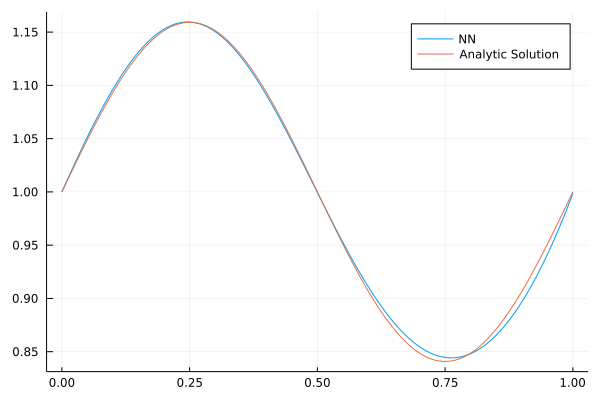

In [82]:
t = 0.0:0.001:1.0 #start:step:end
plot(t, X.(t), label="NN")
plot!(t, 1.0.+sin.(2π.*t)/2π, label="Analytic Solution") 
# This does a great job! 

# Physics-Informed Machine Learning 

Machine learning algorithms map inputs to outputs, but **they don't take advantage of any physical laws we already know**. How can we leverage our well established models to produce *better* neural networks? 

# Example: Harmonic Oscillator
One of the fundamental ideas of physics (and physical science in general) is the idea that we can use differential equations to encode physical laws. Let's leverage this idea to inform the training of a neural network designed to predict the position of a spring-mass system that is driven by some driving force of the form $f\sin(x)$, i.e. 
\begin{equation} 
    x'' = -kx + 0.1\sin(x) 
\end{equation}

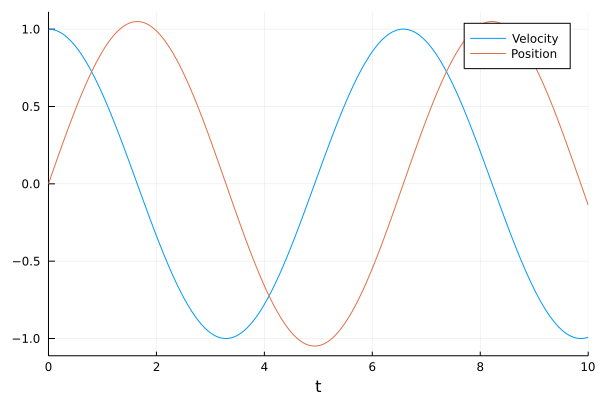

In [84]:
# solve using a standard equation solver 
k = 1.0 
force(dx, x, k, t) = -k*x + 0.1sin(x) 
prob = SecondOrderODEProblem(force, 1.0, 0.0, (0.0, 10.0), k) 
sol = solve(prob)
plot(sol,label=["Velocity" "Position"])

Suppose we want to learn how to predict the force applied on the spring, $F(t)$, but we only have4 sample measurments... 

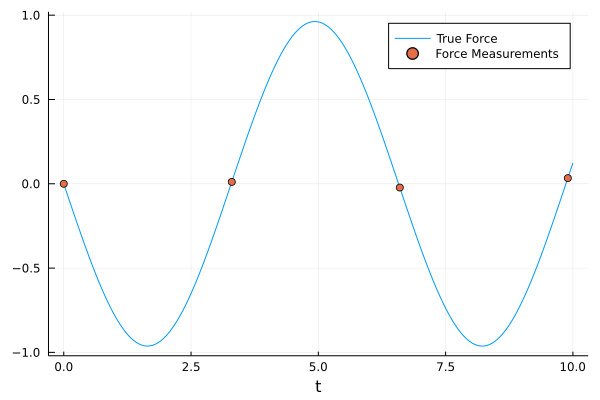

In [85]:
# nice plot of F(t)
plot_t = 0:0.01:10 
data_plot = sol(plot_t)
positions_plot = [state[2] for state in data_plot]
force_plot = [force(state[1], state[2], k, t) for state in data_plot]


# Generate the dataset
t = 0:3.3:10  # four datapoints 
dataset = sol(t)
position_data = [state[2] for state in sol(t)]
force_data = [force(state[1],state[2],k,t) for state in sol(t)]

plot(plot_t,force_plot,xlabel="t",label="True Force")
scatter!(t,force_data,label="Force Measurements")

Let's try to train a neural network to approximate the expected force. Clearly this will be tricky as our 4 samples are not representative of the full range of forces. 

In [86]:
NNForce = Chain(x -> [x], 
            Dense(1, 32, tanh), 
            Dense(32, 1), 
            first)

Chain(#21, Dense(1, 32, tanh), Dense(32, 1), first)

Define a loss function to force the Neural Network to learn the force (MSE) 

\begin{equation}
    L(p) = \sum_i\left( NN(x(t_i), v(t_i), t_i)-F(x(t_i),v(t_i),t_i) \right)^2
\end{equation}

In [88]:
loss() = sum(abs2,NNForce(position_data[i]) - force_data[i] for i in 1:length(position_data))
loss()

0.002474479818330283

In [89]:
opt = Flux.Descent(0.01) # lr 0.01 
data = Iterators.repeated((), 5000)
iter = 0 
cb = function ()
    global iter += 1 
    if iter % 500 == 0 
        display(loss())
    end
end

display(loss())
Flux.train!(loss, Flux.params(NNForce), data, opt, cb=cb)

0.002474479818330283

0.0019518474287581722

0.0016588746135408157

0.0014099251726329485

0.0011981437545047187

0.0010178555097469602

0.0008643279680651014

0.0007335831610790807

0.0006222605235393909

0.0005275081969341189

0.0004468997806938161

So we've learned the dataset well, but how well does the model generalize to predict the forces? 

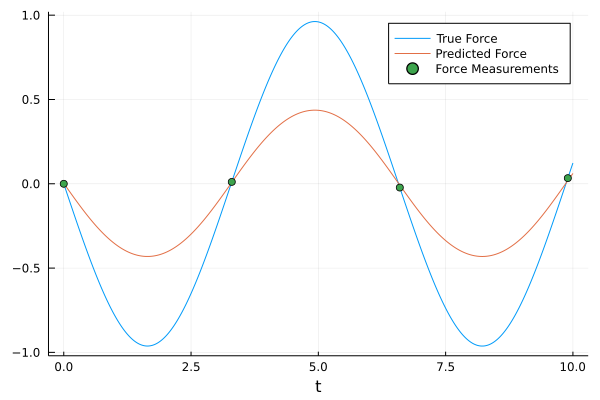

In [91]:
learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

So... not great. The function we fitted does fit the data, but it doesn't capture the *right* function. How can we do better? 

# Cool Idea 2: Harmonic Oscillator *Informed* Training 
Everyone that's ever taken a physics class has learned about Hooke's law, i.e. $F_{spring} = -kx$. Further, the spring constant $k$ is a physical constant that people *have spent a lot of effort measuring for a variety of different systems*. **There is no need to make our Neural Network learn physics from scratch**. 

Suppose that we already know (by someone else's clever measurement) that $k=0.1$. Instead of training the neural network on the entire r.h.s., let's just train it on the residual term (i.e. the forcing function). 

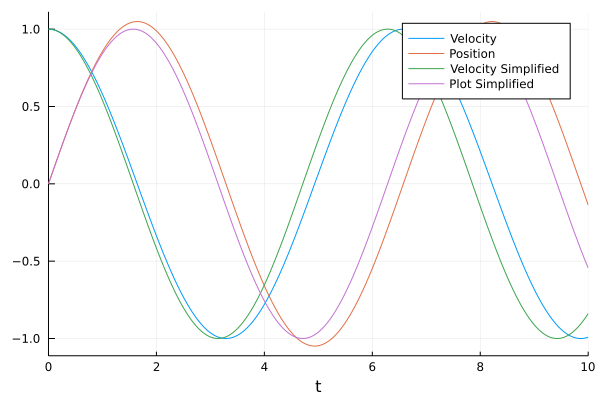

In [93]:
# solve the *easy* problem using numerical methods
force2(dx, x, k, t) = -k*x 
prob_simplified = SecondOrderODEProblem(force2, 1.0, 0.0, (0.0, 10.0), k) 
sol_simplified = solve(prob_simplified) 
plot(sol, label=["Velocity" "Position"])
plot!(sol_simplified, label=["Velocity Simplified" "Plot Simplified"])

Clearly, this simple model does a good job of getting us *close* to the desired solution. Let's use our Neural Network to *build on what we know*. We will do this by adding a regularization term to the loss that enforces we have aggreement with the simple model

In [95]:
random_positions = [2rand()-1 for i in 1:100] # random values in [-1,1]
loss_ode() = sum(abs2,NNForce(x) - (-k*x) for x in random_positions)
loss_ode()

11.357887507447211

In [96]:
λ = 0.1 # a weight factor to control degree of regularization
composed_loss() = loss() + λ*loss_ode()

composed_loss (generic function with 1 method)

1.136235650525415

0.00040448944847203957

0.0003911300275880607

0.0003789795075186483

0.0003678412587433839

0.00035755865284428786

0.00034801055588486683

0.0003391000440079547

0.00033074451497724336

0.00032288090907332606

0.0003154562629884529

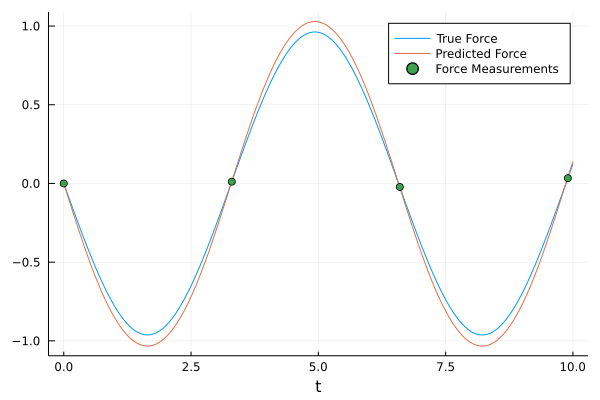

In [97]:
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(composed_loss())
  end
end
display(composed_loss())
Flux.train!(composed_loss, Flux.params(NNForce), data, opt; cb=cb)

learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

This is MUCH better! So, to summarize: 

We can leverage our physics knowledge to approximate some differential equation by a neural net by adding a regularization term to the loss function that enforces first or second order physics. 

# Cool Idea 3: "Univseral" DiffEq's  and Sparse Model Identification
based off of [this](https://arxiv.org/abs/2001.04385) paper by Chris Rackauckas. 

People have been studying the *automatic* reconstruction of models using observational data for some time. The SInDy algorithim is one example of such a strategy which finds a *sparse* basis of functions over some candidate library by minimzing a LASSO-like objective function. 

As a motivating example, consider the Lotka-Volterra predator-prey system: 
\begin{align}
    \dot{x} &= \alpha x - \beta xy \\ 
    \dot{y} &= \gamma xy - \delta y 
\end{align}

Suppose our clever scientist has already (by some other means) evaluated the prey birth rate $\alpha$ and the predator death rate $\delta$. Why not utilize this information and only use Neural Networks for the remaining terms (which we may not yet know), i.e. 

\begin{align}
    \dot{x} &= \alpha x + NN_1(x,y;p_1) \\ 
    \dot{y} &= -\delta y + NN_2(x, y; p_2)
\end{align}

This is called a "universal" differential equations as it makes use of a *universal function approximator* in the form of a Neural Network(s).

In [98]:
# set up function for the ode system 

function lotka!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1]
    du[2] = γ*u[1]*u[2]  - δ*u[2]
end

lotka! (generic function with 1 method)

In [99]:
# Define the experimental parameters
tspan = (0.0f0,3.0f0)
u0 = Float32[0.44249296,4.6280594] # initial conditions for x₀, y₀
p_ = Float32[1.3, 0.9, 0.8, 1.8]

# Solve the problem numerically
prob = ODEProblem(lotka!, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1);

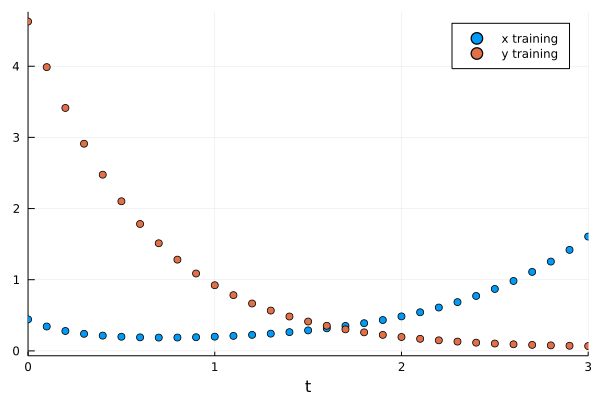

In [100]:
scatter(solution, label=["x training" "y training"], xlabel="t")

In [101]:
# collect the result as training data 
tsdata = Array(solution) 

# add some noise to the data to make the task harder
noisy_data = tsdata + Float32(1e-5)*randn(eltype(tsdata), size(tsdata))

2×31 Matrix{Float32}:
 0.442517  0.342122  0.279391  0.239504  …  1.25468    1.41937    1.60625
 4.62807   3.98766   3.41397   2.91104      0.0771776  0.0717248  0.0676077

Let's set up the new differential equation with the Neural Network for the missing terms

In [104]:
ann = FastChain(FastDense(2, 32, tanh),
    FastDense(32, 32, tanh),
    FastDense(32, 2))

p = initial_params(ann) 

function dudt_(u, p, t)
    x, y = u 
    z = ann(u, p) 
    [p_[1]*x + z[1],-p_[4]*y + z[2]]
end

prob_nn = ODEProblem(dudt_, u0, tspan, p) 
sol = solve(prob_nn, saveat=solution.t); # solve the model NN with the randomly initialized weights

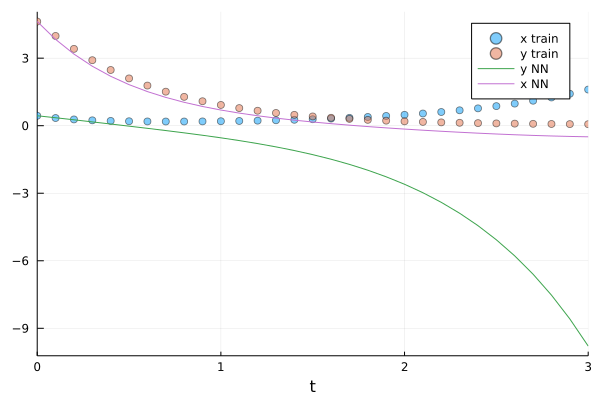

In [106]:
scatter(solution, label=["x train" "y train"], alpha=0.5)
plot!(sol, label=["y NN" "x NN"])
# so... not very good to start with 

In [107]:
# create loss function to fit the NN to the data 

function predict(θ)
    # solve NN ode with parameters θ
    tmp_prob_nn = ODEProblem(dudt_, u0, tspan, θ) 
    Array(solve(tmp_prob_nn, saveat=solution.t))
end

function loss(θ)
    # compute the MSE loss
    pred = predict(θ) 
    sum(abs2, noisy_data .- pred), pred
end

loss(p)[1] # so... pretty high to start

566.68304f0

In [108]:
# create callback function to track training progress 
losses = Float32[] 

function train_callback(θ, l, pred) 
    push!(losses, l)
    if length(losses)%25 == 0
        println(losses[end])
    end
    false # to prevent early stopping functionality
end

train_callback (generic function with 1 method)

In [111]:
using DiffEqFlux
using Optim

In [112]:
# start training with adam
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=train_callback, maxiters=100)

println("Finished the first batch")
# finish training with quasi-newton method 
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=train_callback)

21.775417
12.804028
7.173641
4.4816875
Finished the first batch
0.08032685
0.024302995
0.004852936
0.0036399423
0.0027486754
0.0018215526
0.0009342707
0.0004981829
0.0004168976
0.00024455166
0.00020552993
0.00020049799
0.00011990271
9.479071e-5


u: 1218-element Vector{Float32}:
  0.030169724
 -0.14703089
 -0.25199264
 -0.06944875
  0.102329105
 -0.099341854
 -0.06534748
  0.15459123
  0.37938076
 -0.012395698
  0.15728134
 -0.31830654
  0.074941784
  ⋮
 -0.46214753
  0.44147313
 -0.034886703
 -0.41570252
 -0.07394954
  0.31595004
  0.3365894
 -0.108465835
 -0.044242594
 -0.36929488
 -0.16018015
  0.17663376

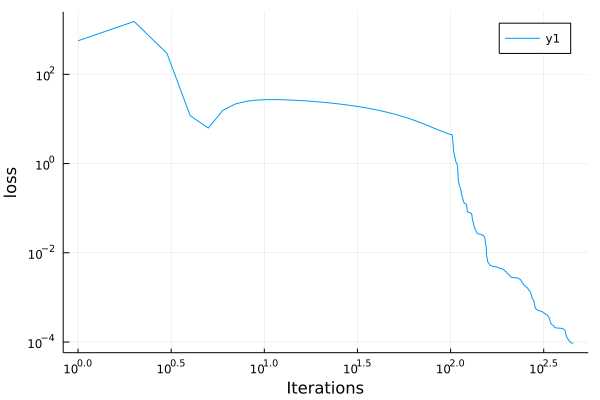

In [113]:
plot(losses, yaxis=:log, xaxis=:log, xlabel="Iterations", ylabel="loss")

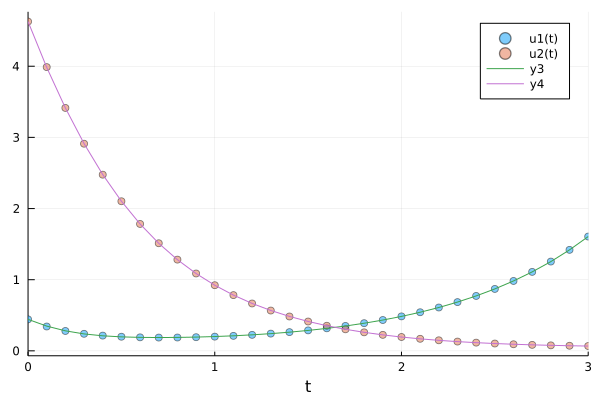

In [114]:
NNsolution = predict(res2.minimizer)

scatter(solution, alpha=0.5 )
plot!(solution.t, NNsolution')

# So we have a great fit to the training data.

Let's check to see how well we've learned the two missing terms in the ODE 

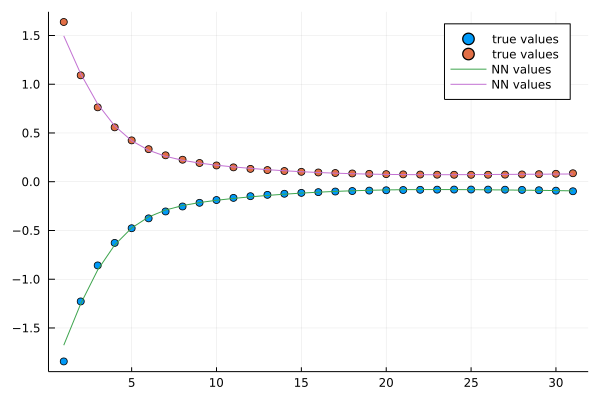

In [115]:
X_data = noisy_data

# collect the βu₁u₂ and γu₁u₂ terms that we are trying to predict
L = [-p_[2]*(X_data[1,:].*X_data[2,:])';p_[3]*(X_data[1,:].*X_data[2,:])'] # true values 
L̂ = ann(X_data, res2.minimizer) # nn fit
scatter(L', label="true values")
plot!(L̂', label="NN values")

So, we see that the Neural Network has done a great job of learning the two cross terms in the differential equation. Given this fit, let's perform a sparse regression of the neural network against a library of basis functions to try and **recover the correct physical model**. 

We will do this using SINDy (Sparse Identification of Nonlinear Dynamics) which performs a regularized regression like LASSO against a library of basis functions. 

In [121]:
using ModelingToolkit, DataDrivenDiffEq

In [122]:
# Create a Basis of polynomials and the sine function
@variables u[1:2]
# Generate the basis functions, multivariate polynomials up to deg 5
# and sine
b = [polynomial_basis(u, 5); sin.(u)]
basis = Basis(b, u)

Model ##Basis#4552 with 23 equations
States (2):
  u₁
  u₂
Parameters (0):

In [123]:
using LinearAlgebra # for the "norm" function 

# Create an optimizer for the SINDy problem
opt = SR3()
# Create the thresholds which should be used in the search process
λ = Float32.(exp10.(-7:0.1:3)) # 10^-7 to 10^3

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

Ψ =  SINDy(X_data, L̂, basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

LoadError: UndefVarError: SINDy not defined

In [120]:
?SINDy

search: sind asind thisind lastindex Signed signed firstindex setindex! Unsigned

Couldn't find SINDy
Perhaps you meant SIEA, SIEB, SVD, DIN99, QNDF or SAMIN


No documentation found.

Binding `SINDy` does not exist.
